In [84]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import rescale_intensity

from sentinelhub import CRS, BBox, DataCollection, SHConfig
from sentinelhub import SentinelHubCatalog
from sentinelhub import SHConfig
from oxeo.core.stac import landsat
from oxeo.core.stac.constants import USWEST_URL ,ELEMENT84_URL
uswest_config = SHConfig()
uswest_config.sh_base_url = USWEST_URL
from oxeo.core.stac.constants import USWEST_URL ,ELEMENT84_URL, LANDSATLOOK_URL, LANDSAT_SEARCH_PARAMS

uswest_catalog = SentinelHubCatalog(config=uswest_config)
eu_catalog = SentinelHubCatalog(SHConfig())
from oxeo.core.data import get_aoi_from_stac_catalog
import os
os.environ["AWS_REQUEST_PAYER"] = "requester"

from oxeo.core.utils import get_bounding_box

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
box = get_bounding_box({"geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              14.911966323852539,
              37.30573714593416
            ],
            [
              14.987583160400392,
              37.30573714593416
            ],
            [
              14.987583160400392,
              37.345050859282736
            ],
            [
              14.911966323852539,
              37.345050859282736
            ],
            [
              14.911966323852539,
              37.30573714593416
            ]
          ]
        ]
      }})

In [4]:
bbox = BBox(box, crs=CRS.WGS84)#BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84) #BBox((-71.40254974365233, -46.9537775782648, -71.26213073730467, -46.89163931213445), crs=CRS.WGS84)#
landsat_time_interval = "1999-12-10", "2015-02-01" 
s1_s2_time_interval = "2020-12-10", "2021-02-01" 

search_params = {
}


In [5]:
s2_aoi = get_aoi_from_stac_catalog(catalog=ELEMENT84_URL,
                                   data_collection="sentinel-s2-l2a-cogs",
                                   bbox=bbox,
                                   time_interval=s1_s2_time_interval,
                                   search_params={})

In [6]:
s2_aoi

,Array,Chunk
Bytes,796.83 MiB,2.23 MiB
Shape,"(21, 17, 436, 671)","(1, 1, 436, 671)"
Count,44268 Tasks,357 Chunks
Type,float64,numpy.ndarray


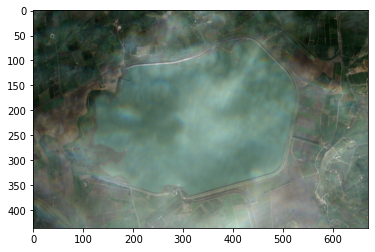

In [7]:
img = s2_aoi.sel(band=["B04","B03","B02"])[:5].mean(axis=0).values.transpose(1,2,0)
plt.imshow(rescale_intensity(img,(np.nanmin(img), np.nanmax(img))))

In [15]:
s1_aoi = get_aoi_from_stac_catalog(catalog=eu_catalog,
                                   data_collection=DataCollection.SENTINEL1,
                                   bbox=bbox,
                                   time_interval=s1_s2_time_interval,
                                   search_params={}, resolution=10)


                                        


In [16]:
vv = s1_aoi.sel(band="vv").mean(axis=0).compute()
vh = s1_aoi.sel(band="vh").mean(axis=0).compute()


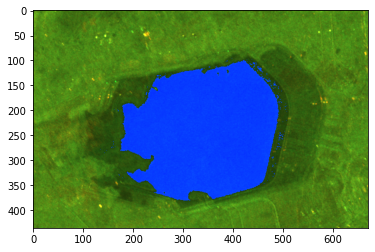

In [17]:
vv_thresh = 80
rgb = np.where(
    vv < vv_thresh,
    [vv, 8 * vv, 0.5 + 3 * vv + 2000 * vh],
    [3 * vv, 1.1 * vv + 8.75 * vh, 1.75 * vh],
).transpose(1, 2, 0)

cutoff = 2000
dis = rescale_intensity(rgb, in_range=(0, cutoff), out_range=(0, 1))

plt.imshow(dis)

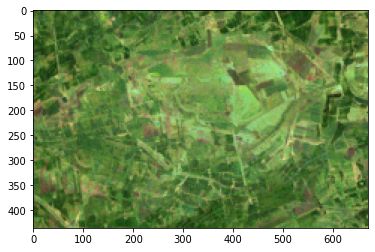

In [19]:
landsat_aoi = get_aoi_from_stac_catalog(catalog="https://landsatlook.usgs.gov/stac-server",
                                   data_collection="landsat-c2l2-sr",
                                   bbox=bbox,
                                   time_interval=landsat_time_interval,
                                   search_params={"query":{"eo:cloud_cover": {
                                                              "gte": 0,
                                                              "lte": 10
                                                    },}},
                                   resolution=10)

img = landsat_aoi.sel(band=["red","green","blue"])[:5].min(axis=0)[:,:,:].values.transpose(1,2,0)
plt.imshow(rescale_intensity(img,(np.nanmin(img), np.nanmax(img))))

# Prediction

In [20]:

import numpy as np


import dask
from distributed import Client


from oxeo.water.models.segmentation import Segmentation2DPredictor, DaskSegmentationPredictor
from oxeo.water.models.segmentation import reconstruct_image_from_patches,stack_preds,reduce_to_timeseries
from oxeo.core.models.tile import load_tile_from_stac_as_dict, load_aoi_from_stac_as_dict, tile_from_id, TilePath, tile_to_geom
from oxeo.core import data
import matplotlib.pyplot as plt
from oxeo.core.constants import BAND_PREDICTOR_ORDER

In [21]:
s2_predictor = DaskSegmentationPredictor(
    ckpt_path="../data/semseg_epoch_012.ckpt",
    fs=None,
    bands=BAND_PREDICTOR_ORDER["sentinel-2"],
)

In [22]:
preds, aoi = s2_predictor.predict_stac_aoi(
    constellation="sentinel-2",
    catalog=ELEMENT84_URL,
    data_collection="sentinel-s2-l2a-cogs",
    bbox=bbox,
    time_interval=s1_s2_time_interval,
    search_params={"query":{"eo:cloud_cover": {
                                                              "gte": 0,
                                                              "lte": 10
                                                    },}},
    resolution=10
)

2022-08-01 17:16:01,144 |     INFO | segmentation_2d:load_model:190 - Loading model from path ../data/semseg_epoch_012.ckpt


In [23]:
stack = stack_preds(preds)
revisits, _, target_h, target_w = aoi.shape
mask = reconstruct_image_from_patches(stack, revisits, target_h, target_w, patch_size=250)

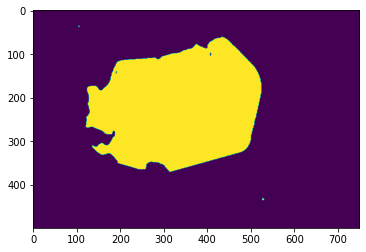

In [24]:
#client =  Client(n_workers=4, threads_per_worker=1, memory_limit="16GB") 

mask_out = mask[:4, :, :].compute()
plt.imshow(mask_out[0])

In [25]:
ts = reduce_to_timeseries(mask_out)
ts_out = ts.compute()
print(ts_out)

[89356 75431 78816 83894]


In [91]:
LANDSAT_SEARCH_PARAMS["query"]  | {
                                "platform": {
                                  "in": ["LANDSAT_5", "LANDSAT_8"]
                                },
                        
                                "eo:cloud_cover": {
                                                              "gte": 0,
                                                              "lte": 10
                                                    },}

{'platform': {'in': ['LANDSAT_5', 'LANDSAT_8']},
 'landsat:collection_category': {'in': ['T1']},
 'eo:cloud_cover': {'gte': 0, 'lte': 10}}

In [93]:
preds, aoi = s2_predictor.predict_stac_aoi(
    constellation="landsat-8",
    catalog=LANDSATLOOK_URL,
    data_collection="landsat-c2l2-sr",
    bbox=bbox,
    time_interval=landsat_time_interval,
    search_params={"query":{

                             
                                "eo:cloud_cover": {
                                                              "gte": 0,
                                                              "lte": 10
                                                    },}},
    resolution=10
)

2022-08-01 18:04:58,337 |     INFO | segmentation_2d:load_model:190 - Loading model from path ../data/semseg_epoch_012.ckpt


In [94]:
aoi.sel(band=["red","green","blue"])[5]

<xarray.DataArray 'stackstac-31ced6e7577088cf03f63e80fb5b7bf0' (band: 3,
                                                                y: 500, x: 750)>
dask.array<getitem, shape=(3, 500, 750), dtype=float64, chunksize=(1, 436, 671), chunktype=numpy.ndarray>
Coordinates: (12/36)
    time                          datetime64[ns] 2000-07-10T09:27:32.853576
    id                            <U43 'LE07_L2SP_188034_20000710_20211119_02...
  * band                          (band) <U13 'red' 'green' 'blue'
  * x                             (x) float64 4.922e+05 4.922e+05 ... nan nan
  * y                             (y) float64 4.133e+06 4.133e+06 ... nan nan
    landsat:wrs_path              <U3 '188'
    ...                            ...
    title                         (band) object None None None
    classification:bitfields      (band) object None None None
    common_name                   (band) object None None None
    center_wavelength             (band) object None None None
    full_width_half_max           object None
    epsg                          int64 32633

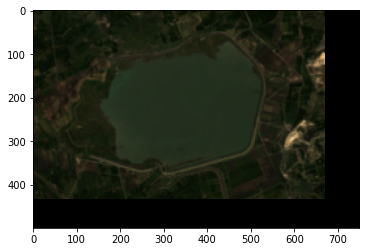

In [96]:
img = aoi.sel(band=["red","green","blue"])[0][:,:,:].values.transpose(1,2,0)
plt.imshow(rescale_intensity(img,(np.nanmin(img), np.nanmax(img))))

In [97]:
stack = stack_preds(preds)
revisits, _, target_h, target_w = aoi.shape
mask = reconstruct_image_from_patches(stack, revisits, target_h, target_w, patch_size=250)

In [ ]:
#client =  Client(n_workers=4, threads_per_worker=1, memory_limit="16GB") 

mask_out = mask[:2].compute()
plt.imshow(mask_out[0])

In [38]:
aoi.sel(band=["red","green","blue"])[1]

<xarray.DataArray 'stackstac-f772fa70804c586f533ac9a10b9e8d93' (band: 3,
                                                                y: 500, x: 750)>
dask.array<getitem, shape=(3, 500, 750), dtype=float64, chunksize=(1, 436, 671), chunktype=numpy.ndarray>
Coordinates: (12/36)
    time                          datetime64[ns] 2000-03-12T09:09:37.346075
    id                            <U43 'LT05_L2SP_188034_20000312_20200907_02...
  * band                          (band) <U13 'red' 'green' 'blue'
  * x                             (x) float64 4.922e+05 4.922e+05 ... nan nan
  * y                             (y) float64 4.133e+06 4.133e+06 ... nan nan
    landsat:wrs_path              <U3 '188'
    ...                            ...
    title                         (band) object None None None
    classification:bitfields      (band) object None None None
    common_name                   (band) object None None None
    center_wavelength             (band) object None None None
    full_width_half_max           object None
    epsg                          int64 32633

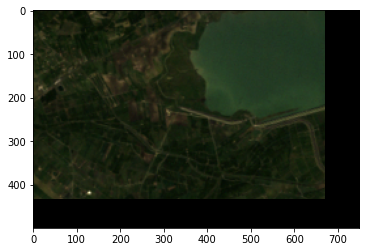

In [58]:
img = aoi.sel(band=["red","green","blue"])[0][:,:,:].values.transpose(1,2,0)
plt.imshow(rescale_intensity(img,(np.nanmin(img), np.nanmax(img))))

In [ ]:
plt.imshow(mask_out[0,:target_h, :target_w])

In [ ]:
ts = reduce_to_timeseries(mask_out)
ts_out = ts.compute()
print(ts_out)

In [ ]:
l8_predictor = Segmentation2DPredictor(ckpt_path="../data/semseg_epoch_012.ckpt", fs=None,
                                    bands=BAND_PREDICTOR_ORDER["landsat-8"],
                                    target_resolution=30)

preds = l8_predictor.predict_stac_aoi(constellation="landsat-8",
                           catalog=LANDSATLOOK_URL,
                           data_collection="landsat-c2l2-sr",
                           bbox=bbox,
                           time_interval=time_interval,
                           search_params={"query":{"eo:cloud_cover": {
                                                              "gte": 0,
                                                              "lte": 10
                                                    },}},
                           revisit=slice(0,2))
plt.imshow(preds[0])